In [ ]:
import os
import numpy as np
import open3d as o3d
import pandas as pd
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('Teste_Peso.csv')

df = df.drop(columns=['erro_L', 'B_erro', 'aspect_ratio', 'pca_ratio_1_0', 'sphericity_pca'])

In [ ]:
def identificar_linha(numero_ovo):
    batch_atual = (numero_ovo - 1) // 200  # Identifica a batch atual
    posicao_na_batch = (numero_ovo - 1) % 200  # Posição do ovo dentro da batch

    linha = (posicao_na_batch % 3) + 1  # Mantém o ciclo correto {1, 2, 3}

    return linha, batch_atual


In [ ]:
# Cria um novo DataFrame vazio para armazenar resultados
df_new = pd.DataFrame()

# Função auxiliar para separar pontos inliers e outliers na nuvem de pontos
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)
    return inlier_cloud

# Lista de arquivos .ply com as nuvens de pontos dos ovos
arquivos_ovos = os.listdir(r'C:\Users\mhmon\ovos-pv\ovos3')

# Carregar planilha com dados reais (medidas manuais)
df = pd.read_csv(r'C:\Users\mhmon\ovos-pv\PLANILHA COMPLETA - CLASSIFICAÇÃO.xlsx - Qualidade ovos (1).csv')
df = df.dropna(subset=["B", "L "])  # Remove linhas sem dados de largura/altura

# Listas para armazenar valores previstos e reais
altura_real_lista = []
largura_real_lista = []
altura_pred_lista = []
largura_pred_lista = []
alturamax_pred_lista = []
df.values

# Loop principal: processa cada ovo da planilha
for i, row in df.iterrows():
    # Escalas iniciais (ajuste empírico)
    escala = 1.07
    escalab = 1.04

    # Nome e número do ovo
    num = row['N_OVO ']
    nome = 'ovo' + str(num)
    arquivo = f'C:\\Users\\mhmon\\ovos-pv\\ovos3\\{nome}.ply'
    numero_ovo = int(nome.replace('ovo', ''))  # Extrai número do ovo do nome

    # Considera apenas ovos dentro do intervalo de interesse
    if not (numero_ovo <= 1000):
        continue

    # Ajustes de escala conforme a bandeja
    if (numero_ovo > 200 and numero_ovo < 400):
        escala = 1.06
    if (numero_ovo > 600 and numero_ovo < 690):
        escala = 1.05
    if (numero_ovo > 690 and numero_ovo < 801):
        escala = 1.1
    if (numero_ovo > 720 and numero_ovo < 790):
        escala = 1.12
        escalab = 1.06

    # Verifica se o arquivo da nuvem de pontos existe
    if not os.path.exists(arquivo):
        print(f"Arquivo {arquivo} não encontrado, pulando...")
        continue

    print(arquivo)

    # Carrega a nuvem de pontos (.ply)
    pcd = o3d.io.read_point_cloud(arquivo)
    points = np.asarray(pcd.points)

    # Aplica PCA para alinhar o ovo com os eixos principais
    mean = np.mean(points, axis=0)
    points_centered = points - mean
    U, S, Vt = np.linalg.svd(points_centered)
    rotated_points = np.dot(points_centered, Vt.T)

    # Cria uma nova nuvem de pontos alinhada
    pcd_aligned = o3d.geometry.PointCloud()
    pcd_aligned.points = o3d.utility.Vector3dVector(rotated_points)

    # Remove outliers estatísticos
    cl, ind = pcd_aligned.remove_statistical_outlier(nb_neighbors=20, std_ratio=2)
    pcd_aligned = display_inlier_outlier(pcd_aligned, ind)
    # o3d.visualization.draw_geometries([pcd_aligned])  # Visualização opcional

    # Calcula o casco convexo (hull) da nuvem
    hull, _ = pcd_aligned.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)

    # Calcula dimensões 2D (projeção XY)
    from scipy.spatial import ConvexHull
    hull_2d = ConvexHull(rotated_points[:, :2])
    width_2d = np.max(hull_2d.points[:, 0]) - np.min(hull_2d.points[:, 0])
    height_2d = np.max(hull_2d.points[:, 1]) - np.min(hull_2d.points[:, 1])

    # Estima largura e altura considerando escala
    largura_prevista = (height_2d * 1000) * escalab
    linha, batch = identificar_linha(numero_ovo)
    if linha == 1:
        escala += 0.02
    altura_prevista = (width_2d * 1000) * escala

    # Armazena previsões
    altura_pred_lista.append(altura_prevista)
    largura_pred_lista.append(largura_prevista)

    # Recupera medidas reais da planilha
    linha_correta = df[df["N_OVO "] == num]
    lreal = float(linha_correta["B"].values[0].replace(",", "."))
    areal = float(linha_correta["L "].values[0].replace(",", "."))

    altura_real_lista.append(areal)
    largura_real_lista.append(lreal)

    # Cálculo dos erros (diferença entre predito e real)
    erro_altura = altura_prevista - areal
    erro_largura = largura_prevista - lreal

    # Distância máxima entre dois pontos da nuvem (medida auxiliar)
    from scipy.spatial.distance import pdist
    max_dist = np.max(pdist(points)) * 1000 * escala
    alturamax_pred_lista.append(max_dist)
    erro_max = max_dist - areal

    # Cria nova linha de resultados e adiciona ao DataFrame final
    nova_linha = pd.DataFrame([{
        'nome': f'{nome}.ply',
        'L_estimado': altura_prevista,
        'L': areal,
        'B': lreal,
        'erro_L': erro_altura,
        # 'max_dist': max_dist,
        # 'erro_max': erro_max,
        'B_estimado': largura_prevista,
        'B_erro': erro_largura,
        'linha': linha,
        'batch': batch
    }])

    df_new = pd.concat([df_new, nova_linha], ignore_index=True)

    # print(f"Ovo {nome}:")
    # print(f"  [M1] Altura prevista:  {altura_prevista:.2f} mm | Real: {areal:.2f} mm | Erro: {erro_altura:.2f} mm")
    # print(f"  [M1] Largura prevista: {largura_prevista:.2f} mm | Real: {lreal:.2f} mm | Erro: {erro_largura:.2f} mm")
    # print(f"  MaxDist:               {max_dist:.2f} mm | MaxDist-Real: {erro_max:.2f} mm")
    # if abs(erro_altura) < abs(erro_max):
    #     print("UEPA")
    # print("-" * 40)


In [ ]:
from sklearn.model_selection import train_test_split
df = df_new
# df_resultado = df_resultado.drop(columns=['linha','batch'])
df_treino, df_teste = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
print(df_treino.describe())
print(df_teste.describe())



       L_estimado           L           B      erro_L  B_estimado      B_erro  \
count  629.000000  629.000000  629.000000  629.000000  629.000000  629.000000   
mean    58.355870   58.719300   44.505628   -0.363430   44.416568   -0.089060   
std      2.424442    2.065576    1.358134    1.450786    1.597567    0.936656   
min     48.558600   50.330000   38.550000   -5.631790   38.507062   -4.254530   
25%     56.681530   57.300000   43.590000   -1.209567   43.427680   -0.552888   
50%     58.350514   58.630000   44.490000   -0.207840   44.492311    0.023786   
75%     60.021558   60.100000   45.380000    0.685453   45.435705    0.489207   
max     66.744103   64.440000   48.970000    5.750495   48.747587    4.389324   

            linha       batch  
count  629.000000  629.000000  
mean     2.004769    1.917329  
std      0.803045    1.471438  
min      1.000000    0.000000  
25%      1.000000    1.000000  
50%      2.000000    2.000000  
75%      3.000000    3.000000  
max      3.000

In [ ]:
altura_real = np.array(df['L'].tolist())
largura_real = np.array(df['B'].tolist())
largura_prev = np.array(df['B_estimado'].tolist())
altura_prev = np.array(df['L_estimado'].tolist())


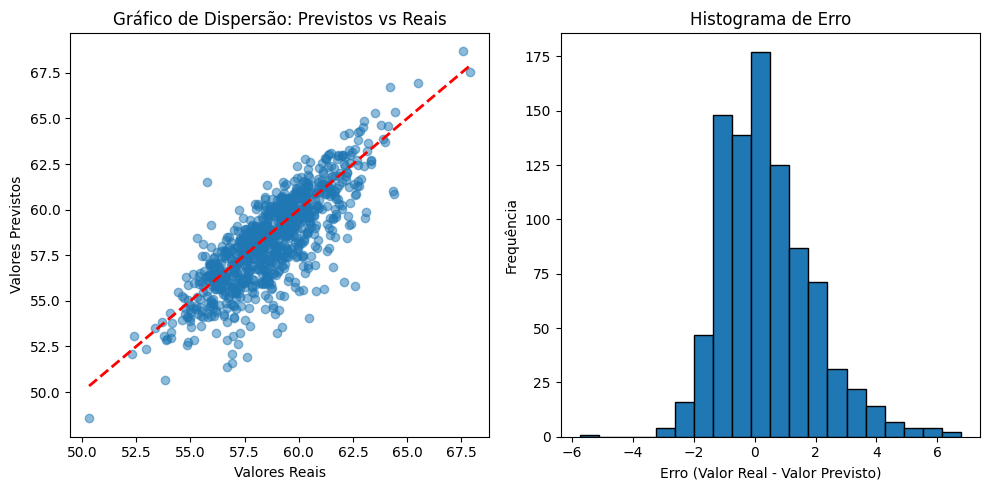

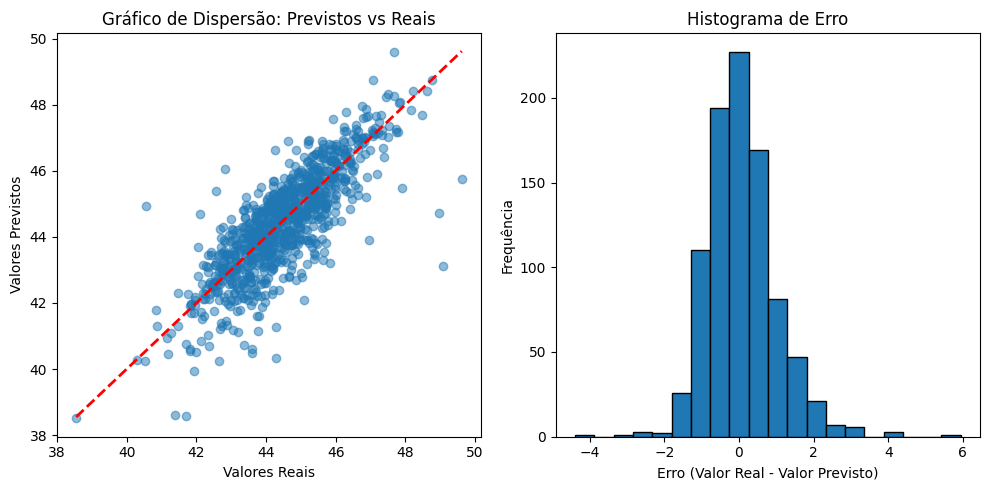

In [ ]:
def plot_predictions_vs_actuals(y_true, y_pred):

     # Gráfico de dispersão
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.title('Gráfico de Dispersão: Previstos vs Reais')

    # Histograma de erro
    erros = y_true - y_pred
    plt.subplot(1, 2, 2)
    plt.hist(erros, bins=20, edgecolor='black')
    plt.xlabel('Erro (Valor Real - Valor Previsto)')
    plt.ylabel('Frequência')
    plt.title('Histograma de Erro')

    plt.tight_layout()
    plt.show()


plot_predictions_vs_actuals(altura_real, altura_prev)
plot_predictions_vs_actuals(largura_real, largura_prev)


In [ ]:
print(df_b0['linha'].value_counts())
print(df_b1['linha'].value_counts())
print(df_b2['linha'].value_counts())
print(df_b3['linha'].value_counts())
print(df_b4['linha'].value_counts())

linha
2    10
3     8
1     3
Name: count, dtype: int64
linha
3    19
2    16
1     4
Name: count, dtype: int64
linha
1    15
2    11
3     1
Name: count, dtype: int64
linha
3    15
2    10
1     8
Name: count, dtype: int64
linha
2    19
3    17
1    10
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# altura_real = np.array(altura_real_lista)
# largura_real = np.array(largura_real_lista)
# largura_prev = np.array(largura_pred_lista)
# altura_prev = np.array(altura_pred_lista)
# altura_prevmax = np.array(alturamax_pred_lista)
pred_list = [altura_prev]


for item in pred_list:
    mae = mean_absolute_error(altura_real, item)
    mse = mean_squared_error(altura_real, item)
    rmse = np.sqrt(mse)
    r2 = r2_score(altura_real, item)

    print(f"MAE : {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")


MAE : 1.1680908987179603
MSE: 2.453634249914947
RMSE: 1.5664080726027132
R²: 0.45406692047123165


In [ ]:
mae = mean_absolute_error(largura_real, largura_prev)
mse = mean_squared_error(largura_real, largura_prev)
rmse = np.sqrt(mse)
r2 = r2_score(largura_real, largura_prev)

print(f"MAE : {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {rmse}")



MAE : 0.6915906948261163
MSE: 0.8705939646292237
RMSE: 0.9330562494454574
R2: 0.9330562494454574
